# Identifying and analysing the graphs & sub-graphs in the CrowdTangle dataset

In this notebook, we use CrowdTangle Facebook data to create and analyse networks, find sub-graphs, communities and inspect nodes of interests. The workflow uses [NetworkX python library](https://networkx.org). 

Networks are usually described by two sets of items, which ultimately "form" a network: `Nodes` and `Edges`. In mathematical terms, this is known as a `Graph`. Nodes and edges can have metadata associated with them (picture courtesy: T. McKinney). 

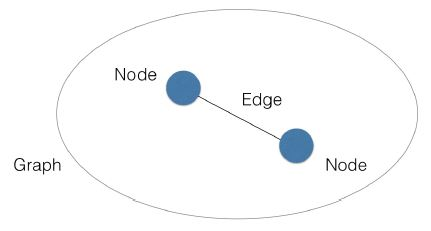


For basic introduction to network analysis, please see [DataCamp's GitHub page](https://github.com/trenton3983/DataCamp/blob/master/2020-05-21_intro_to_network_analysis_in_python.ipynb). You can also check out Trenton McKinney's Notebook [here](https://trenton3983.github.io/files/projects/2020-05-21_intro_to_network_analysis_in_python/2020-05-21_intro_to_network_analysis_in_python.html).

## Section A. Installations and dataset
---



In this section, we install and import necessary python packagaes, load the historical csv dataset downloaded from CrowdTangle (as pandas dataframe), and enquire the column names, total number of data entries etc. 

### Install and import packages

In [ ]:
!pip install nxviz

     |████████████████████████████████| 3.7 MB 11.7 MB/s 
     |████████████████████████████████| 11.2 MB 36.6 MB/s 
     |████████████████████████████████| 5.1 MB 38.6 MB/s 
     |████████████████████████████████| 900 kB 53.0 MB/s 
     |████████████████████████████████| 76 kB 5.5 MB/s 
     |████████████████████████████████| 216 kB 55.5 MB/s 
     |████████████████████████████████| 1.1 MB 50.3 MB/s 
     |████████████████████████████████| 561 kB 46.5 MB/s 
     |████████████████████████████████| 181 kB 41.5 MB/s 
     |████████████████████████████████| 132 kB 54.5 MB/s 
     |████████████████████████████████| 130 kB 59.3 MB/s 
     |████████████████████████████████| 428 kB 56.5 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 5.3.5


In [ ]:
!pip install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 10.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nxviz 0.7.3 requires matplotlib>=3.3.3, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
from pathlib import Path
import requests
import networkx as nx
import nxviz as nv
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime, date
from pprint import pprint as pp
from itertools import combinations
import random
from collections import Counter, defaultdict
import numpy as np
import statistics as stats
import operator

/usr/local/lib/python3.7/dist-packages/nxviz/__init__.py:29: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  """


In [ ]:
print(f'NetworkX version: {nx.__version__}')
print(f'Matplotlib version: {mpl.__version__}')

NetworkX version: 2.6.3
Matplotlib version: 3.1.3


### Load the dataset

Below we load the csv dataset from the Google Drive folder. In the `PATH_TO_YOUR_DIRECTORY` string insert the path to your Google Drive folder where your csv dataset is located.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/PATH_TO_YOUR_DIRECTORY")

In [ ]:
import pandas as pd
import time

Below we load the csv data as pandas dataframe.

In [ ]:
csv_data = pd.read_csv("FILENAME.csv", low_memory=False,  lineterminator='\n', sep=';', error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


Let us now enquire the shape of the dataset and print available columns to the dataset

In [ ]:
csv_data.shape

(70886, 40)

In [ ]:
csv_data.columns

Index(['account.name', 'account.handle', 'platformId', 'Page Category',
       'Page Admin Top Country', 'Page Description', 'Page Created',
       'subscriberCount', 'Followers at Posting', 'date', 'Post Created Date',
       'Post Created Time', 'type', 'totalInteraction',
       'statistics.actual.likeCount', 'statistics.actual.commentCount',
       'statistics.actual.shareCount', 'statistics.actual.loveCount',
       'statistics.actual.wowCount', 'statistics.actual.hahaCount',
       'statistics.actual.sadCount', 'statistics.actual.angryCount',
       'statistics.actual.careCount', 'Video Share Status', 'Is Video Owner?',
       'statistics.actual.videoPostViewCount',
       'statistics.actual.videoTotalViewCount',
       'statistics.actual.videoAllCrosspostsViewCount', 'Video Length',
       'postUrl', 'message', 'expandedLinks.original',
       'expandedLinks.expanded', 'imageText', 'title', 'description',
       'brandedContentSponsor.platformId', 'brandedContentSponsor.name',
 

In [ ]:
# show the csv data set
display(csv_data)

## Section B. Computation of the graph(s) from the CrowdTangle dataset
---

In this section we compute the nodes and edges of the whole graph, and by using the `NetworkX` python package, create the graph. 

It is possible to choose any `source` and `target` field as one wishes. Some possible examples are:



> `source`: account.name, `target`: explandedLinks => shows the mapping of accounts and shared links.

> `source`: account.name, `target`: category => shows what account falls in which category.

> `source`: account.name, `target`: type => shows which account shares what types of posts the most, e.g., Videos, Photos etc.

The `nodes.csv` and `edges.csv` files created below can be imported to visualisation softwares like Gephi to make interactive visualisations. 

### Compute the graph edges and nodes

In [ ]:
nodelist = pd.DataFrame({'pagename':csv_data ['account.name'],'category':csv_data['Page Category'], 'type':csv_data['type'], 'link':csv_data['expandedLinks.original']})

In [ ]:
edges = pd.DataFrame({'source':nodelist.iloc[:,0], 'target':nodelist.iloc[:,2]})

In [ ]:
nodelist.to_csv('nodes.csv',index=False) # save the nodelist into csv 

In [ ]:
edges.to_csv('edges.csv',index=False) # save the edges into csv 

In [ ]:
print (edges)

Compute the graph from the pandas edges dataframe

In [ ]:
 graph = nx.from_pandas_edgelist(edges, "source", "target")

## Section C. Analysis of the full graph
---

### Visualization of the full network

See NetworkX draw documentation [here](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html). The networkX draw has a `pos` argument as below, which needs to be computed.

> `pos`: dictionary

> A dictionary with nodes as keys and positions as values. If not specified a spring layout positioning is computed.


Let's create a spring layout for pos argument

In [ ]:
pos = nx.spring_layout(graph, k=0.05)

Let's now plot the graph

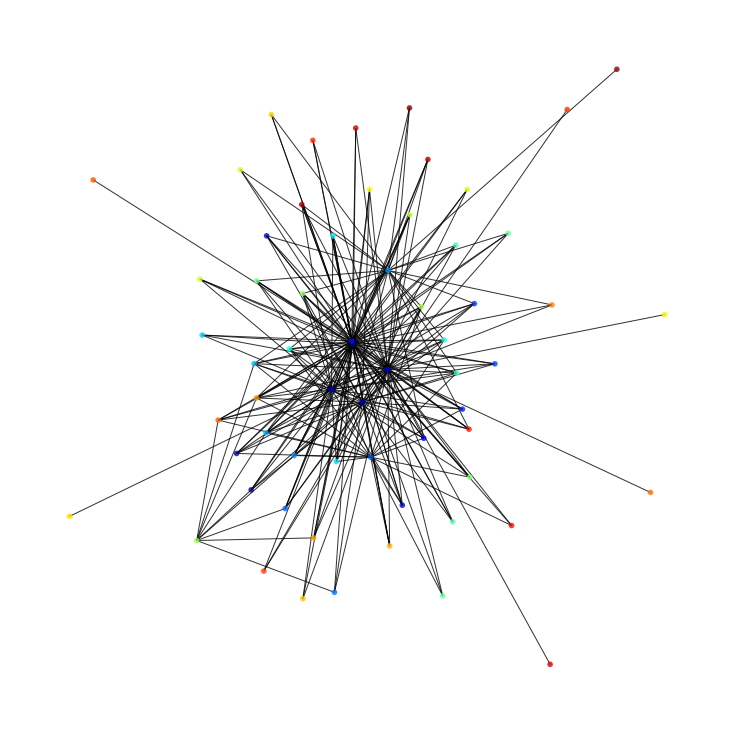

In [ ]:
plt.figure(figsize = (10,10))
nx.draw(graph, pos=pos, node_color=range(len(graph)), cmap=plt.cm.jet, edge_color="black", linewidths=0.1, node_size=30, alpha=0.8, with_labels=False)
plt.show()

### Analysis & statistics of the full graph

Let us now compute the total number of nodes and edges present in the full graph

In [ ]:
print(f"There are {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges present in the Graph")

There are 62 nodes and 248 edges present in the Graph


**Degrees**

Let's look at the *degree* (how many edges each node has). This is a common centrality measure, which gives an idea of how 'imporant' each node is in the network. In other words, the number of neighbors that a node has is called its "degree".

The assumption is that nodes with the most edges are the most important/central as they are directly connected to lots of other nodes. Nodes with a high centrality might be expected to play important roles in network. 

[Source](https://deepnote.com/@deepnote/An-Introduction-to-Social-Network-Analysis-with-NetworkX-Two-Factions-of-a-Karate-Club-w4wQvz-rTpeKZpx8DrlyrQ).

Let's now compute the maximum and minimum degree of the graph.

In [ ]:
degrees = [val for (node, val) in graph.degree()]
print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")  

The maximum degree of the Graph is 49
The minimum degree of the Graph is 1


In [ ]:
print(f"The average degree of the nodes in the Graph is {np.mean(degrees):.1f}")  

The average degree of the nodes in the Graph is 8.0


**Connected graph**

A connected graph is a graph that is connected in the sense of a topological space, i.e., there is a path from any point to any other point in the graph.

So, let's now compute whether the graph is connected or not!

In [ ]:
if nx.is_connected(graph):
    print("The graph is connected")
else:
    print("The graph is not connected")

The graph is connected


We can also enquire the number of connected components in the graph.

In [ ]:
print(f"There are {nx.number_connected_components(graph)} connected components in the Graph")  

There are 1 connected components in the Graph


### Graph centrality analysis

**Degree centrality**

This is one of many metrics we can use to evaluate the importance of a node, and is simply defined as *the number of neighbors that a node has divided by the total number of neighbors that the node could possible have*: 


> (Number of neighbors a node has) / (Number of neighbors the node could possibly have)



There are two scenarios possible here:

* if self-loops are allowed, such as in a network mapping of all bike trips in a bike sharing system, then the number of neighbors that I could possibly have, is every single node in the graph, including myself.

* if self-loops are not allowed, such as in the Twitter social network, where, by definition, my account cannot follow itself, the the number of neighbors I could possibly have is every other node in the graph, excluding myself.


In real life, example of nodes in a graph that have high degree centrality might be:
* Twitter broadcasters, that is, users that are followed by many other users
* Airport transportation hubs, such as New York, London or Tokyo
* Disease super-spreaders, who are the individuals that epidemiologists would want to track down to help stop the spread of a disease. 

[Source](https://github.com/trenton3983/DataCamp/blob/master/2020-05-21_intro_to_network_analysis_in_python.ipynb)

In [ ]:
degrees = [len(list(graph.neighbors(n))) for n in graph.nodes()]

graph_centrality = nx.degree_centrality(graph)
max_de = max(graph_centrality.items(), key=operator.itemgetter(1))

Let's plot a histogram of the degree centrality distribution of the graph.

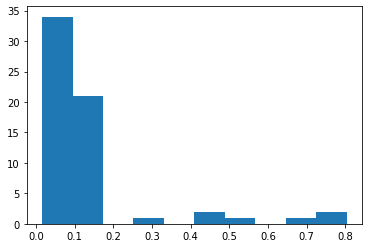

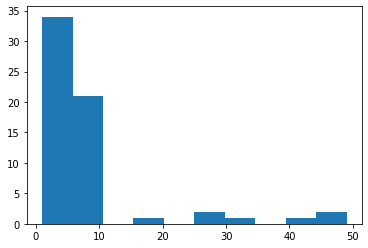

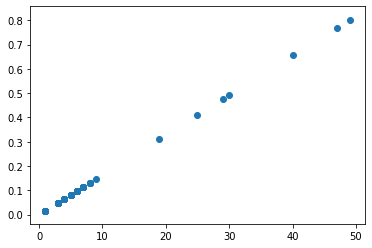

In [ ]:
plt.figure()
plt.hist(list(graph_centrality.values()))
#plt.xlim(0.002, 0.01)
plt.show()

# Plot a histogram of the degree distribution of the graph
plt.figure()
plt.hist(degrees)
plt.show()

# Plot a scatter plot of the centrality distribution and the degree distribution
plt.figure()
plt.scatter(degrees, list(graph_centrality.values()))
plt.show()

**Closeness centrality**

In a connected graph, closeness centrality (or closeness) of a node is a measure of centrality in a network, calculated as the *reciprocal of the sum of the length of the shortest paths between the node and all other nodes in the graph*. 

Thus, the more central a node is, the closer it is to all other nodes.

[Source](https://en.wikipedia.org/wiki/Closeness_centrality)

In [ ]:
graph_closeness = nx.closeness_centrality(graph)
max_clo = max(graph_closeness.items(), key=operator.itemgetter(1))

**Betweenness Centrality**

> Definition: (Number of shortest paths through node) / (All possible shortest paths)


In other words: the number of shortest paths in a graph that pass through a node, divided by the number of shortest paths that exist between every pair of nodes in a graph.

*All shortest paths* are the set of paths in a graph, such that **each path is the shortest path between a given pair of nodes, done for all pairs of nodes.**

* This metric captures a different view of importance - in essence, it captures bottleneck nodes in a graph, rather that highly connected nodes.

* One example would be individuals that bridge between to communities: 
An individual bridging liberal-leaning and conservative-leaning users

* Alternatively, consider the Internet, where there are crucial links that bridge two network of computers. If we removed those crucial nodes in the Internet, then information will not flow (or at least not as easily) between subnetworks.

[Source](https://github.com/trenton3983/DataCamp/blob/master/2020-05-21_intro_to_network_analysis_in_python.ipynb)

In [ ]:
graph_betweenness = nx.betweenness_centrality(graph, normalized=True, endpoints=False)
max_bet = max(graph_betweenness.items(), key=operator.itemgetter(1))

In [ ]:
print(f"the node with id {max_de[0]} has a degree centrality of {max_de[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

the node with id Native Video has a degree centrality of 0.80 which is the maximum of the Graph
the node with id Native Video has a closeness centrality of 0.78 which is the maximum of the Graph
the node with id Native Video has a betweenness centrality of 0.31 which is the maximum of the Graph


Create a scatter plot of between-ness centrality and degree centrality

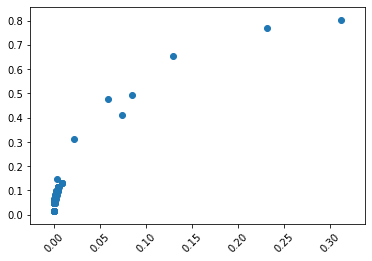

In [ ]:
plt.scatter(list(graph_betweenness.values()), list(graph_centrality.values()))
# Display the plot
#plt.xlim(-0.00005, 0.009)
plt.xticks(rotation=45)
plt.show()

## Section D. Analysis of the sub-graphs, cliques, communities and nodes
---

The largest sub-graph is the largest connected component of the network.

### Analysis of the largest sub-graph and its visualization

In [ ]:
Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
G0 = graph.subgraph(Gcc[0])

print(f"There are {G0.number_of_nodes()} nodes and {G0.number_of_edges()} \
edges present in the largest component of the Graph")

if nx.is_connected(G0):
    print("The largest sub-graph is connected")
else:
    print("The largest sub-graph is not connected")

There are 62 nodes and 248 edges present in the largest component of the Graph
The largest sub-graph is connected


**Local clustering coefficient** 

The local clustering coefficient can be thought of as the average probability that a pair of node i’s `friends` are also `friends` with each other. In other words, it measures the extent to which any given node is located within a tight 'cluster' of neighbouring nodes.

For the mathematical definition see [here](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html#networkx.algorithms.cluster.clustering). 

Ref: [Source](https://deepnote.com/@deepnote/An-Introduction-to-Social-Network-Analysis-with-NetworkX-Two-Factions-of-a-Karate-Club-w4wQvz-rTpeKZpx8DrlyrQ).

In [ ]:
print(f"The average clustering coefficient is {nx.average_clustering(G0)} in the largest subgraph")
print(f"The transitivity of the largest subgraph is {nx.transitivity(G0)}")

The average clustering coefficient is 0.0 in the largest subgraph
The transitivity of the largest subgraph is 0


In [ ]:
print(f"The diameter of our largest sub-graph is {nx.diameter(G0)}")
print(f"The average distance between any two nodes in the largest sub-graph is {nx.average_shortest_path_length(G0):.2f}")

The diameter of our largest sub-graph is 4
The average distance between any two nodes in the largest sub-graph is 2.03


Plotting the largest sub-graph

In [ ]:
pos0 = nx.spring_layout(G0, k=0.05)

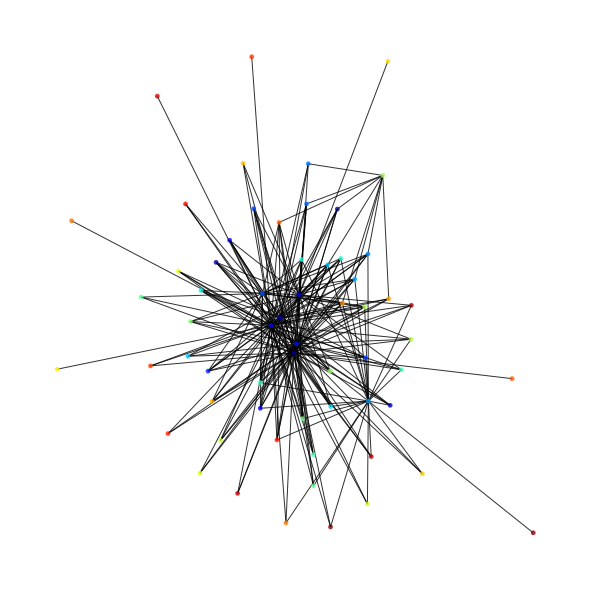

In [ ]:
plt.figure(figsize = (8,8))
nx.draw(G0, pos=pos0, node_color=range(len(G0)), cmap=plt.cm.jet, edge_color="black", linewidths=0.2, node_size=20, alpha=0.8, with_labels=False)
plt.show()

### Cliques, communities & nodes of interest

**Clique**

In network theory, a clique is essentially defined as
a set of nodes that are completely connected by an edge to every other node in the set.

It is, then, a completely connected graph.

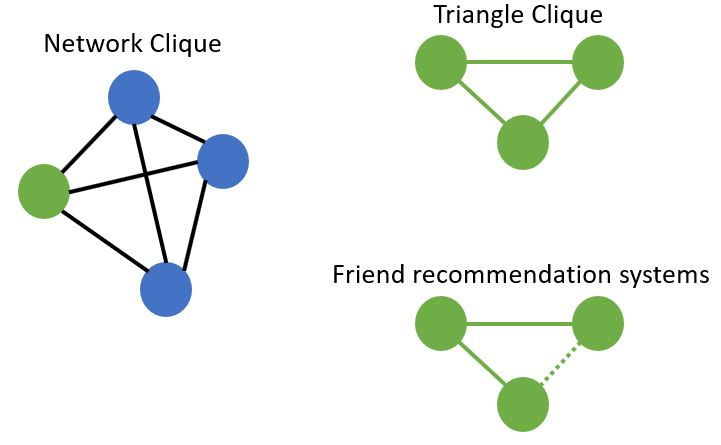

Ref: [source](https://github.com/trenton3983/DataCamp/blob/master/2020-05-21_intro_to_network_analysis_in_python.ipynb)

In [ ]:
gl = list(nx.find_cliques(graph))
print(gl)

[['I Support Pupspendra Kulshrestha', 'Photo'], ['YouTube', 'Arif Aajakia And Pushpendra Kulshrestha Fan Club'], ['YouTube', 'Pushpendra kulshrestha followers'], ['YouTube', 'Pushpendra Kulshrestha Fan Club'], ['YouTube', 'Pushpendra kulshreshtha Fans'], ['YouTube', 'पुष्पेंद्र कुलश्रेष्ठ एवं यती नरसिंहानंद सरस्वती जी फैंस क्लब'], ['YouTube', 'रमेश सैनी काफ़िर'], ['YouTube', 'Pushpendra Kulshreshtha Fans'], ['YouTube', 'पुष्पेंद्र कुलश्रेष्ठ फैन क्लब'], ['YouTube', 'पुष्पेन्द्र कुलश्रेष्ठ फैंस क्लब'], ['YouTube', 'Pushpendra Kulshrestha fans'], ['YouTube', 'पुष्पेन्द्रफैंस'], ['YouTube', 'Pushpendra Kulshrestha Fans'], ['YouTube', 'Pushpendra Kulshrestha fan'], ['YouTube', 'We Support Pushpendra Kulshrestha'], ['YouTube', 'Pushpendra Kulshrestha Inspiration'], ['YouTube', 'Support Pushpendra Kulshrestha'], ['YouTube', 'Pushpendra kulshrestha fans club'], ['YouTube', 'पुष्पेन्द्र कुलश्रेष्ठ  - राष्ट्र भक्त'], ['YouTube', 'पुष्पेंद्र कुलश्रेष्ठ : public 24x 7 Club'], ['YouTube', 'Pushpen

**Maximal clique**

They are a clique, but that clique can't be extended by adding another node in the graph.

* For example, the sub-clique of the 3 green nodes (on the left of the picture below) can be extended by one blue node to form a large clique. As such, these 3 green nodes do not form a maximal clique in the graph.

* The 4 nodes connected as a clique together on the right of the picture below, cannot be extended and still remain a clique, as the remaining node is not fully connected to the other four nodes. As such, these four nodes constitute a maximal clique.

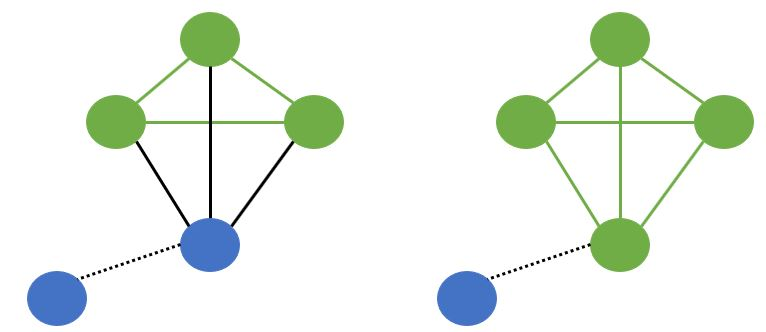

Ref: [source](https://github.com/trenton3983/DataCamp/blob/master/2020-05-21_intro_to_network_analysis_in_python.ipynb)

Let's now define a function that finds all maximal cliques in a grpah, of a certain size.

In [ ]:
def maximal_cliques(G, n):
    """
    Finds all maximal cliques in graph `G` that are of size `n`.
    """
    mcs = []
    for clique in nx.find_cliques(G):
        if len(clique) == n:
            mcs.append(clique)
    return mcs

In [ ]:
mcs = maximal_cliques (graph, 2) #number of cliques with size n
print (len(mcs))

248


**Communities**

The concept of maximal cliques has its uses in community finding algorithms. Cliques form a good starting point for finding communities, as they are fully connected subgraphs within a larger graph.

By identifying these maximal cliques, one naive way of identifying communities might be identifying *the unions of maximal cliques that share some number of members, but are also of some minimum size*.

Ref: [source](https://github.com/trenton3983/DataCamp/blob/master/2020-05-21_intro_to_network_analysis_in_python.ipynb)

Let's perform the community detection and find our how many communities are detected

In [ ]:
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

#preform the community detection
c = list(greedy_modularity_communities(graph))

#Let's find out how many communities we detected
print(len(c))

4


Let's print the above clusters explicitly

In [ ]:
#Lets print these clusters
community_0 = sorted(c[0])
community_1 = sorted(c[1])
community_2 = sorted(c[2])
community_3 = sorted(c[3])

print(community_0)
print(community_1)
print(community_2)
print(community_3)

['I am with Pushpendra kulshrestha', 'Native Video', 'Pushpendra', 'Pushpendra Kulshreshtha Fans', 'Pushpendra Kulshresth Fans', 'Pushpendra Kulshrestha Fans Club', 'Pushpendra Kulshrestha- Rashtrawadi', 'Pushpendra kulshrestha', 'Pushpendra kulshrestha Supporters', 'Video', 'We Support Pushpendra Kulshrestha', 'इंजी पुष्पेन्द्र सिंह यादव', 'पुष्पेंद्र कुलश्रेष्ठ एवं यती नरसिंहानंद सरस्वती जी फैंस क्लब', 'पुष्पेंद्र कुलश्रेष्ठ फैंस', 'पुष्पेंद्र कुलश्रेष्ठ फैंस क्लब', 'पुष्पेंद्र जी', 'श्रेष्ठ हिन्दू वक्ता पुष्पेंद्र कुलश्रेष्ठ', 'हिन्दू वक्ता पुष्पेन्द्र कुलश्रेष्ठ']
['Arif Aajakia And Pushpendra Kulshrestha Fan Club', 'I Support Pupspendra Kulshrestha', 'Photo', 'Pushpendra Kulshrestha Fan Club', 'Pushpendra Kulshrestha Inspiration', 'Pushpendra kulshreshtha Fans', 'Pushpendra kulshrestha fans club', 'Pushpendra kulshrestha followers', 'Pushpendra kulshrestha supporters', 'Pushpendra kulshrestha telugu fans', 'Support Pushpendra Kulshrestha', 'YouTube', 'पुष्पेंद्र कुलश्रेष्ठ "एक नई 

Let's draw each set of nodes in a seperate colour

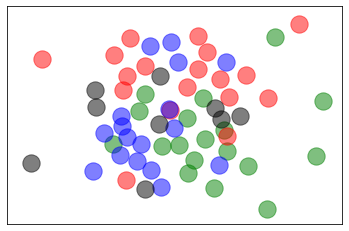

In [ ]:
nx.draw_networkx_nodes(graph, pos, nodelist=community_0, node_color='g', alpha=0.5)
nx.draw_networkx_nodes(graph, pos, nodelist=community_1, node_color='r', alpha=0.5)
nx.draw_networkx_nodes(graph, pos, nodelist=community_2, node_color='b', alpha=0.5)
nx.draw_networkx_nodes(graph, pos, nodelist=community_3, node_color='k', alpha=0.5)

plt.show()

Let's draw first two community graphs only

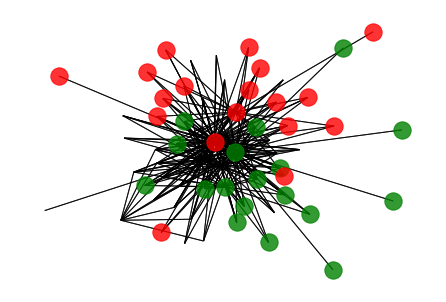

In [ ]:
nx.draw(graph, pos, nodelist=community_0, node_color='g', alpha=0.8,  with_labels=False)
nx.draw(graph, pos, nodelist=community_1, node_color='r', alpha=0.8,  with_labels=False)

plt.show()

### Nodes of interest

Let us now define a function that returns a subgraph of a graph with only specific nodes of interests and their neighbors. 

In [ ]:
def get_nodes_and_nbrs(G, nodes_of_interest):
    """
    Returns a subgraph of the graph `G` with only the `nodes_of_interest` and their neighbors.
    """
    nodes_to_draw = []

    # Iterate over the nodes of interest
    for n in nodes_of_interest:

        # Append the nodes of interest to nodes_to_draw
        nodes_to_draw.append(n)

        # Iterate over all the neighbors of node n
        for nbr in G.neighbors(n):

            # Append the neighbors of n to nodes_to_draw
            nodes_to_draw.append(nbr)

    return G.subgraph(nodes_to_draw)

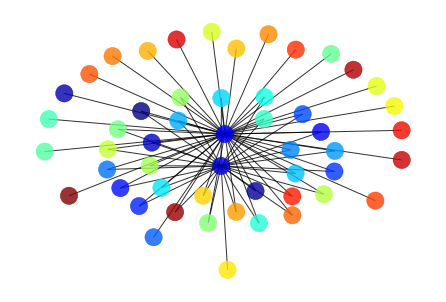

In [ ]:
nodes_of_interest = ['Link', 'Native Video']

# Extract the subgraph with the nodes of interest: T_draw
T_draw = get_nodes_and_nbrs(graph, nodes_of_interest)

# Draw the subgraph to the screen
nx.draw(T_draw, node_color=range(len(T_draw)), alpha=0.8, cmap=plt.cm.jet, edge_color="black", linewidths=0.5, with_labels=False)
plt.show()